In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def wrap_around(i, size):
    """Helper function, to wrap indicies around a grid. Only works for square matrices."""
    return i % size


def flatten(a):
    """Flatten a n dimensional array into a n-1 dimensional array."""
    return a.reshape(-1, a.shape[-1])


def lookup(grid, location):
    """Helper function to look up a value in a given grid. Takes an array with an x and y coordinate."""
    return grid[tuple(location)]


def find_spaces(grid, value):
    """Helper function to find indices of a specific value."""
    return np.argwhere(grid == value)


def adjacent(space):
    """Calculates the indices of the adjacent spaces"""
    return flatten(np.array([space + np.array(adj) for adj in [[-1, 0], [0, 1], [1, 0], [0, -1]]]))


def find_adjacent(spaces, grid_size):
    """For a list of spaces, find all adjacent, and wrap around the grid."""
    return np.array([wrap_around(adjacent(space), grid_size) for space in spaces])


def check_availability(spaces, grid):
    return np.array([space for space in spaces if lookup(grid, space) == 0])


def get_subgrid(grid, origin, size=(7, 7)):
    x_size, y_size = grid.shape
    x_origin, y_origin = origin

    x_offset = int(size[0] / 2 if size[0] % 2 == 0 else (size[0] - 1) / 2)
    y_offset = int(size[1] / 2 if size[1] % 2 == 0 else (size[1] - 1) / 2)
    
    x_indices = wrap_around(np.arange(x_origin - x_offset, x_origin + x_offset + 1, dtype='int8'), x_size)
    y_indices = wrap_around(np.arange(y_origin - y_offset, y_origin + y_offset + 1, dtype='int8'), y_size)
    
    subgrid = np.zeros(size, dtype='int8')
    index_grid = np.zeros((size[0], size[1], 2), dtype='int8')

    for i, x in enumerate(x_indices):
        for j, y in enumerate(y_indices):
            subgrid[i, j] = grid[x, y]
            index_grid[i, j] = np.array([x, y])

    return subgrid, index_grid

Samples in dataset: 531
Dark: Open, Yellow: Closed, Green: Private


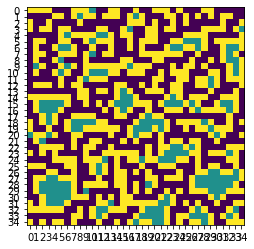

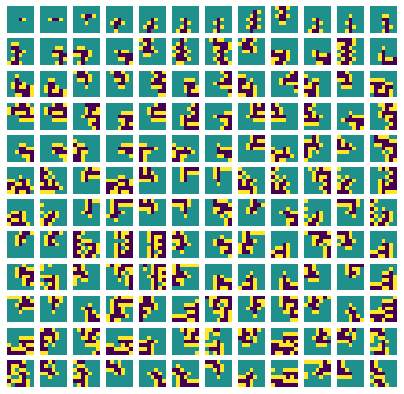

In [9]:
# the goal is to build two datasets of row and random aggregation samples of 7x7
# the samples will then be fed to a svm for classification
x_random = []

# INITIALIZATION

# -- constants
AGGREGATION = "random"
GRID_SIZE = 35
ORIENTATIONS = [[-1, 0], [0, 1], [1, 0], [0, -1]]

# -- initialize empty grid
grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype="int8")

# -- start with a random location.
start_position = np.random.randint(0, GRID_SIZE, size=2)
start_orientation = wrap_around(start_position + np.random.permutation(ORIENTATIONS)[0], GRID_SIZE)

# -- apply start location
grid[tuple(start_position)] = -1
grid[tuple(start_orientation)] = 1 

# -- Save a copy of the subgrid for the dataset
subgrid, index_grid = get_subgrid(grid, start_position)
x_random.append(subgrid)

# INTERATION, RANDOM AGGREGATION

STEPS = 500

for i in range(STEPS):
    # 1. find space which contain an 'open' cell, those with value '-1' in the subgrid
    open_spaces = find_spaces(grid, -1)

    # 2. if selecting from subgrid, we need to get the indices which correspond with the global grid.
    # open_spaces_indices = [lookup(index_grid, space) for space in open_spaces]

    # 3. find all adjacent spaces, for each 'open' cell, and wrap around if need be
    adjacent_spaces = flatten(find_adjacent(open_spaces, GRID_SIZE))

    # 4. check if they are empty or have the value '0'
    available_positions = check_availability(adjacent_spaces, grid)

    # 5. calculate indices for the orientations
    orientations_per_position = find_adjacent(available_positions, GRID_SIZE)
    
    # 6. calculate which orientations are available, have a value of '0'
    available_orientations = np.array([check_availability(o, grid) for o in orientations_per_position])

    # 6b. shuffle orientations and positions
    p = np.random.permutation(np.arange(0, len(available_positions)))
    available_positions = available_positions[p]
    available_orientations = available_orientations[p]

    # 7. pick on position
    for position, orientations in zip(available_positions, available_orientations):    
        # 8. if orientation exist, pick one, else move on to the next position.
        if len(orientations) > 0:
            orientation = np.random.permutation(orientations)[0]
            
            # 8. apply to grid
            grid[tuple(position)] = -1
            grid[tuple(orientation)] = 1
            
            # 9. get new sub and index grid, and add to dataset.        
            subgrid, index_grid = get_subgrid(grid, position)
            x_random.append(subgrid)
            break
    

plt.imshow(grid)
plt.gca().set_xticks(np.arange(0, GRID_SIZE))
plt.gca().set_yticks(np.arange(0, GRID_SIZE))

# -- print dataset samples
fig, axs = plt.subplots(12, 12, figsize=(7,7))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(x_random[i])
    ax.set_xticks(np.arange(0, 7))
    ax.set_yticks(np.arange(0, 7))
    ax.axis('off')

plt.savefig('random_samples.png')
print("Samples in dataset:", len(x_random))
print('Dark: Open, Yellow: Closed, Green: Private')

In [32]:
np.save('random_aggr_450.npy', x_random)

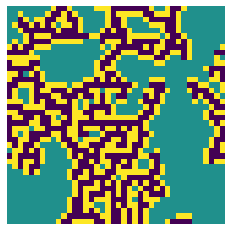

In [4]:
plt.imshow(grid)
plt.gca().set_xticks(np.arange(0, GRID_SIZE))
plt.gca().set_yticks(np.arange(0, GRID_SIZE))
plt.axis('off')

plt.savefig('random_aggr_450.png')

531


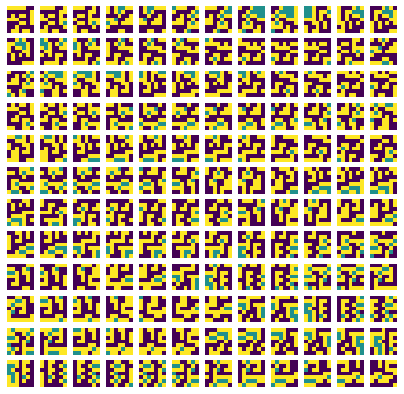

In [10]:
x_complete = []

for space in find_spaces(grid, -1):
    subgrid, _ = get_subgrid(grid, space)
    x_complete.append(subgrid)

fig, axs = plt.subplots(12, 12, figsize=(7,7))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(x_complete[i])
    ax.set_xticks(np.arange(0, 7))
    ax.set_yticks(np.arange(0, 7))
    ax.axis('off')

plt.savefig('random_complete.png')
np.save('random_complete.npy', x_complete[:450])
print(len(x_complete))